# Flight Price Forecast - Kiwi

## Table of Contents
- [Introduction](#Introduction)
- [Imports](#Imports)
- [Data Preprocessing](#Data-Preprocessing)
- [Linear Regression](#linear-regression)
- [Desition Tree](#Desion-Tree)
- [Gaussian Process Regression](#Gaussian-Process-Regression)
- [Random Forest](#Random-Forest)
- [GridSearchCV](#GridSearchCV)
- [KNN Regressor](#KNN-Regressor)
- [MLP Regressor](#MLPRegressor)
- [XG Boost Regressor](#XGBoost-Regressor)
- [Hist Gradient Boosting](#Hist-Gradient-Boosting)
- [Best Performance with Best Parameters](#Best-Performance-with-Best-Parameters)
- [Feature Importance](#Feature-Importance)
- [Conclustions](#Conclustion)


#### Introduction:
##### The provided Python code develops a machine learning pipeline for predicting flight prices, starting with data preprocessing such as cleaning and converting price data, date extraction, duration conversion, and numeric encoding of categorical features like flight stops. The pipeline evaluates multiple regression methods, including Linear Regression, Decision Trees, Gaussian Process, Random Forests (with GridSearchCV optimization), K-Nearest Neighbors, Multi-layer Perceptron, XGBoost, and HistGradientBoostingRegressor, comparing their performance using metrics like R², RMSE, MSE, and MAE.
#### Our Top models: "Random Forest", "XGBoost", and "HistGradientBoosting" regressors demonstrated the strongest predictive performances, while significantly outperforming basic linear models. <br> Using visualization tools such as residual plots, permutation importance, and predicted-versus-actual graphs provided insights into model accuracy and feature relevance.

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.inspection import permutation_importance

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Data Preprocessing

In [4]:
# טענת הנתונים
df = pd.read_csv('flight_data_kiwi_allsnaps_clean.csv')

# הצצה לנתונים
print(df.head())
print(df.info())

    Snap Date    Dep Date Return Date  Outbound Dep Time Dep Duration  \
0  2025-03-02  2025-03-03  2025-03-04  Outbound    11:50       1h 10m   
1  2025-03-02  2025-03-03  2025-03-04  Outbound    13:20       1h 20m   
2  2025-03-02  2025-03-03  2025-03-04  Outbound    18:35       1h 20m   
3  2025-03-02  2025-03-03  2025-03-04  Outbound    07:10       1h 20m   
4  2025-03-02  2025-03-03  2025-03-04  Outbound    19:25       1h 15m   

  Dep Arrival From  Stops Landing  Inbound Back Time Back Duration  \
0       14:00  SEN      0     CDG  Inbound     14:10        1h 15m   
1       15:40  LTN      0     CDG  Inbound     14:10        1h 15m   
2       20:55  LTN      0     CDG  Inbound     14:10        1h 15m   
3       09:30  LTN      0     CDG  Inbound     14:10        1h 15m   
4       21:40  LGW      0     ORY  Inbound     14:10        1h 15m   

  Back Arrival From.1  Stops.1 Landing.1 Dep Company Back Company  Price  
0        14:25    ORY        0       LHR     easyJet      easyJet

In [5]:
# 1. בדיקה שהעמודה קיימת
print(df.columns)

# 2. הצצה בכמה ערכים ראשונים
print(df['Price'].head(10))

# 3. בדיקת סוג העמודה
print("Column type:", df['Price'].dtype)

# 4. אם היא כבר float, אולי אין צורך בהחלפה. 
#    אם היא object/string, ננסה לנקות תווים.

df['Price'] = df['Price'].astype(str)  # ממיר הכל למחרוזת, אם עדיין לא
df['Price'] = df['Price'].str.replace('₪', '', regex=False)
df['Price'] = df['Price'].str.replace(',', '', regex=False)

# 5. בדיקת ערכים חריגים
unique_vals = df['Price'].unique()
print(unique_vals[:50])  # תצוגה של 50 ערכים ראשונים

# 6. המרה למספרים
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# 7. בדיקת כמה NaN נוצרו
nan_count = df['Price'].isna().sum()
print("Number of NaN after conversion:", nan_count)

# אם יש NaN, מחליטים איך לטפל: להסיר שורות? למלא ערך ממוצע? וכו'
df = df.dropna(subset=['Price'])  # לדוגמה, הסרה של שורות בלי מחיר תקין


Index(['Snap Date', 'Dep Date', 'Return Date', 'Outbound', 'Dep Time',
       'Dep Duration', 'Dep Arrival', 'From', 'Stops', 'Landing', 'Inbound',
       'Back Time', 'Back Duration', 'Back Arrival', 'From.1', 'Stops.1',
       'Landing.1', 'Dep Company', 'Back Company', 'Price'],
      dtype='object')
0    ₪ 434
1    ₪ 434
2    ₪ 434
3    ₪ 444
4    ₪ 454
5    ₪ 454
6    ₪ 452
7    ₪ 463
8    ₪ 485
9    ₪ 485
Name: Price, dtype: object
Column type: object
[' 434' ' 444' ' 454' ' 452' ' 463' ' 485' ' 481' ' 479' ' 487' ' 488'
 ' 495' ' 493' ' 505' ' 503' ' 509' ' 510' ' 507' ' 515' ' 516' ' 520'
 ' 531' ' 527' ' 526' ' 529' ' 525' ' 539' ' 537' ' 544' ' 540' ' 548'
 ' 546' ' 561' ' 557' ' 564' ' 570' ' 568' ' 563' ' 566' ' 569' ' 418'
 ' 428' ' 438' ' 436' ' 448' ' 466' ' 460' ' 472' ' 476' ' 477' ' 486']
Number of NaN after conversion: 0


In [6]:
df.head()

,Snap Date,Dep Date,Return Date,Outbound,Dep Time,Dep Duration,Dep Arrival,From,Stops,Landing,Inbound,Back Time,Back Duration,Back Arrival,From.1,Stops.1,Landing.1,Dep Company,Back Company,Price
0,2025-03-02,2025-03-03,2025-03-04,Outbound,11:50,1h 10m,14:00,SEN,0,CDG,Inbound,14:10,1h 15m,14:25,ORY,0,LHR,easyJet,easyJet,434
1,2025-03-02,2025-03-03,2025-03-04,Outbound,13:20,1h 20m,15:40,LTN,0,CDG,Inbound,14:10,1h 15m,14:25,ORY,0,LHR,easyJet,easyJet,434
2,2025-03-02,2025-03-03,2025-03-04,Outbound,18:35,1h 20m,20:55,LTN,0,CDG,Inbound,14:10,1h 15m,14:25,ORY,0,LHR,easyJet,easyJet,434
3,2025-03-02,2025-03-03,2025-03-04,Outbound,07:10,1h 20m,09:30,LTN,0,CDG,Inbound,14:10,1h 15m,14:25,ORY,0,LHR,easyJet,easyJet,444
4,2025-03-02,2025-03-03,2025-03-04,Outbound,19:25,1h 15m,21:40,LGW,0,ORY,Inbound,14:10,1h 15m,14:25,ORY,0,LHR,easyJet,easyJet,454


In [7]:
df['Snap Date'] = pd.to_datetime(df['Snap Date'])
df['Dep Date'] = pd.to_datetime(df['Dep Date'])
df['Return Date'] = pd.to_datetime(df['Return Date'])
df['dep_weekday'] = df['Dep Date'].dt.weekday  # ערך 0-6
df['dep_day'] = df['Dep Date'].dt.day         # ערך 1-31
df['dep_month'] = df['Dep Date'].dt.month     # ערך 1-12
df['is_weekend'] = df['dep_weekday'].apply(lambda x: 1 if x>=5 else 0)

In [8]:
def convert_duration_to_minutes(duration_str):
    # לדוגמה: "1h 20m" -> 80
    parts = duration_str.split()
    total_minutes = 0
    for p in parts:
        if 'h' in p:
            total_minutes += int(p.replace('h', '')) * 60
        elif 'm' in p:
            total_minutes += int(p.replace('m', ''))
    return total_minutes

df['Dep Duration (min)'] = df['Dep Duration'].apply(convert_duration_to_minutes)
df['Back Duration (min)'] = df['Back Duration'].apply(convert_duration_to_minutes)
df['TTT'] = (df['Dep Date'] - df['Snap Date']).dt.days

In [9]:
features = ['Stops','Dep Duration (min)','Back Duration (min)','dep_weekday','dep_day','dep_month',]
for i in features:
    X = df[features]
    y = df['Price']
# הסרה של שורות בהן יש NaN בפיצ’רים
df.dropna(subset=features, inplace=True)

## Model Training

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # אימון
    model.fit(X_train, y_train)
    
    # ניבוי
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # חישוב מדדים
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    
    print(f"=== {model_name} ===")
    print(f"Train -> R2: {r2_train:.3f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"Test  -> R2: {r2_test:.3f},  MSE: {mse_test:.2f},  RMSE: {rmse_test:.2f},  MAE: {mae_test:.2f}")
    
    # Residual Plot
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6,4))
    palette = sns.color_palette("viridis", n_colors=10) 
    color = palette[4]
    sns.scatterplot(x=y_pred_test, y=residuals, color=color, alpha=0.6, edgecolor='black')
    plt.axhline(y=0, color='r', linestyle='dashed', linewidth=2)
    plt.title(f"{model_name} - Residual Plot (Test)")
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual (y_test - y_pred)")
    plt.show()
    
    return model


## Linear Regression

=== Linear Regression ===
Train -> R2: 0.233, MSE: 24705.11, RMSE: 157.18, MAE: 126.13
Test  -> R2: 0.234,  MSE: 24792.40,  RMSE: 157.46,  MAE: 126.19


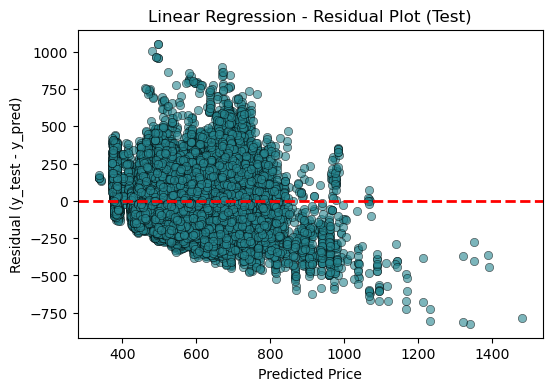

=== Linear Regression (StandardScaler) ===
Train -> R2: 0.233, MSE: 24705.11, RMSE: 157.18, MAE: 126.13
Test  -> R2: 0.234,  MSE: 24792.40,  RMSE: 157.46,  MAE: 126.19


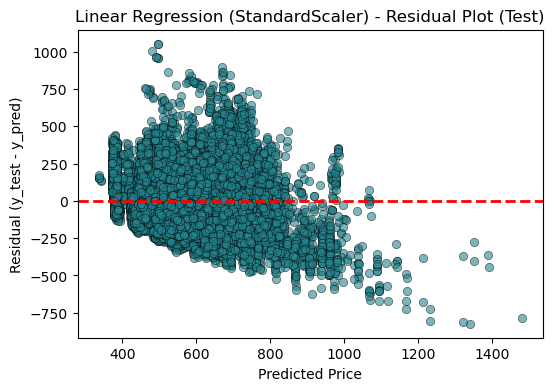

=== Linear Regression (MinMaxScaler) ===
Train -> R2: 0.233, MSE: 24705.11, RMSE: 157.18, MAE: 126.13
Test  -> R2: 0.234,  MSE: 24792.40,  RMSE: 157.46,  MAE: 126.19


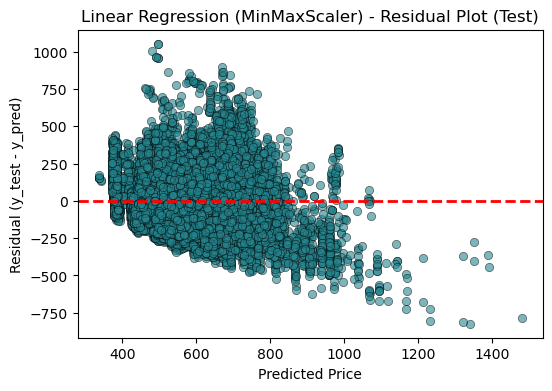

In [92]:
linreg = LinearRegression()
linreg = train_and_evaluate_model(linreg, X_train, y_train, X_test, y_test, "Linear Regression")

linreg_std = LinearRegression()
linreg_std = train_and_evaluate_model(linreg_std, X_train, y_train, X_test, y_test, "Linear Regression (StandardScaler)")

linreg_mm = LinearRegression()
linreg_mm = train_and_evaluate_model(linreg_mm, X_train, y_train, X_test, y_test, "Linear Regression (MinMaxScaler)")

### Conclusions
The graph presents a residual plot for linear regression applied to flight price data.<br>
Or atleast it's trying to... (Bad for predictions in our data) <br>

Key metrics:<br>
R² (Train) = 0.234, R² (Test) = 0.233 → Linear regression explains only 23.3% of the variance in prices, which is quite low. <br>
MSE (Test) = 24,680.09, RMSE (Test) = 157.10, MAE (Test) = 126.28 → Significant prediction errors.<br>
Residuals are not randomly distributed, indicating that the model does not fit well<br>

## Decision-Tree

=== Decision Tree (max_depth=3) ===
Train -> R2: 0.404, MSE: 19204.47, RMSE: 138.58, MAE: 106.14
Test  -> R2: 0.404,  MSE: 19267.87,  RMSE: 138.81,  MAE: 106.10


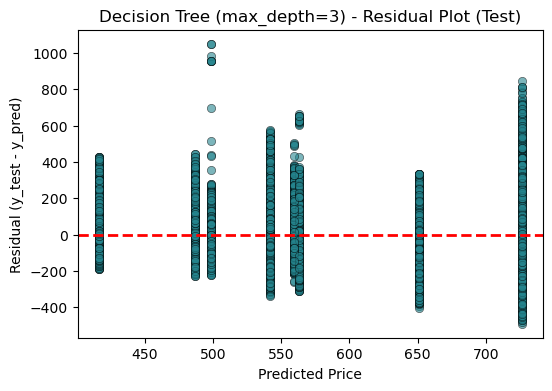

=== Decision Tree (max_depth=5) ===
Train -> R2: 0.518, MSE: 15544.09, RMSE: 124.68, MAE: 95.67
Test  -> R2: 0.520,  MSE: 15534.21,  RMSE: 124.64,  MAE: 95.41


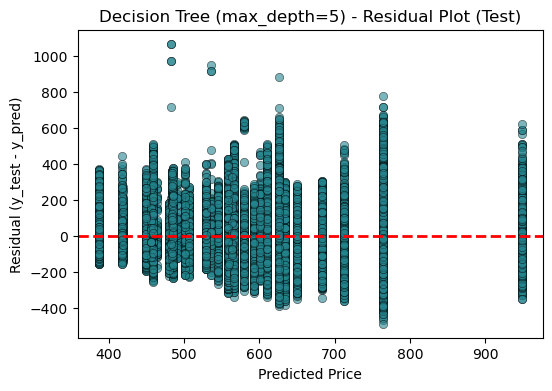

=== Decision Tree (max_depth=7) ===
Train -> R2: 0.584, MSE: 13415.05, RMSE: 115.82, MAE: 88.77
Test  -> R2: 0.584,  MSE: 13444.12,  RMSE: 115.95,  MAE: 88.75


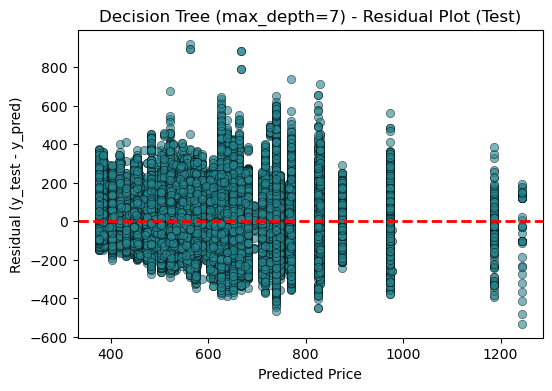

In [93]:
for max_depth in [3, 5, 7]:
    dt = DecisionTreeRegressor(max_depth=max_depth)
    model_name = f"Decision Tree (max_depth={max_depth})"
    dt = train_and_evaluate_model(dt, X_train, y_train, X_test, y_test, model_name)


### Our conclusions
Improvement in Model Performance <br>
When testing the Decision Tree with max_depth=7, we observed a significant improvement:<br>

* R² increased from 0.23 (Linear Regression) to 0.58 → This means that the model now explains 58% of the variance in the data, compared to only 23%.
* max_depth=7 → Better accuracy, more balanced results
* Explains 58% of the variance, residuals are more dispersed, fewer sharp "jumps."
* MSE decreased significantly, indicating a reduction in prediction errors.
* MAE also decreased, meaning the model's predictions are now closer to the actual values.

Increasing tree depth improved accuracy, but structured residuals persist.
We will try a more advanced model.

## Gaussian Process Regression

=== GPR with RBF(length_scale=1) ===
Train -> R2: 0.986, MSE: 630.98, RMSE: 25.12, MAE: 7.16
Test  -> R2: -9.299,  MSE: 333182.71,  RMSE: 577.22,  MAE: 536.64


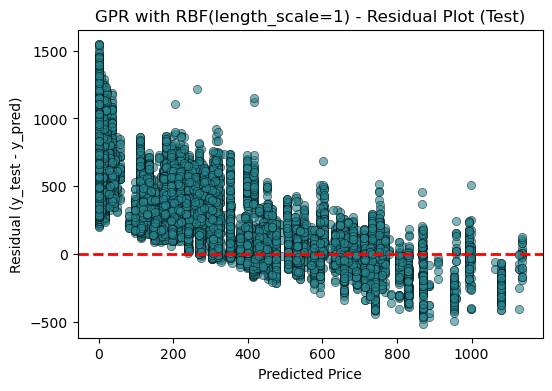

=== GPR with DotProduct(sigma_0=1) ===
Train -> R2: 0.353, MSE: 28612.96, RMSE: 169.15, MAE: 141.82
Test  -> R2: 0.176,  MSE: 26650.99,  RMSE: 163.25,  MAE: 129.06


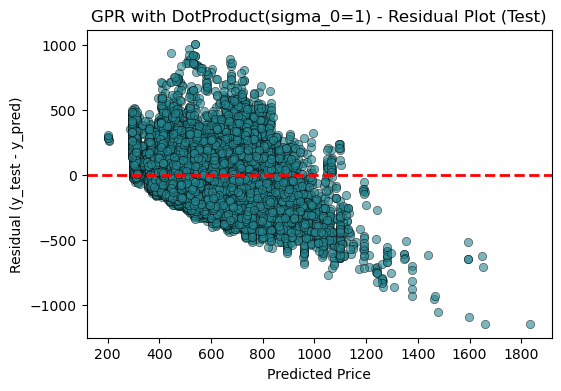

In [ ]:
subset_size = 100  # למשל 100 דוגמאות
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

for kernel in [RBF(length_scale=1.0), DotProduct()]:
    try:
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            optimizer=None,       # ביטול האופטימיזציה
            alpha=1e-6,           # להבטיח יציבות במספרים
        )
        model_name = f"GPR with {kernel}"
        gpr = train_and_evaluate_model(gpr, X_train_sub, y_train_sub, X_test, y_test, model_name)
    except Exception as e:
        print(f"Error with kernel {kernel}: {e}")




### Our conclusions:
* The RBF Kernel caused severe overfitting → Poor performance on new data.
* The DotProduct Kernel slightly improved generalization, but performance is still weak.
* GPR is not the best fit for this problem 

# Random Forest

=== Random Forest (max_depth=3) ===
Train -> R2: 0.406, MSE: 19149.25, RMSE: 138.38, MAE: 105.94
Test  -> R2: 0.406,  MSE: 19209.00,  RMSE: 138.60,  MAE: 105.89


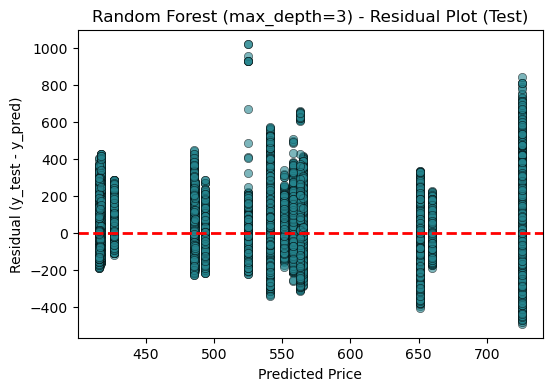

=== Random Forest (max_depth=5) ===
Train -> R2: 0.524, MSE: 15356.38, RMSE: 123.92, MAE: 94.97
Test  -> R2: 0.526,  MSE: 15337.16,  RMSE: 123.84,  MAE: 94.71


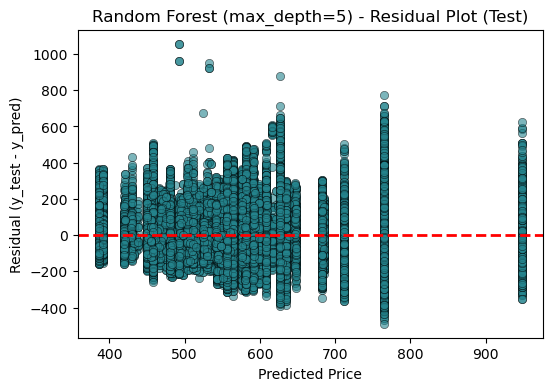

=== Random Forest (max_depth=8) ===
Train -> R2: 0.619, MSE: 12276.29, RMSE: 110.80, MAE: 84.80
Test  -> R2: 0.618,  MSE: 12367.04,  RMSE: 111.21,  MAE: 85.03


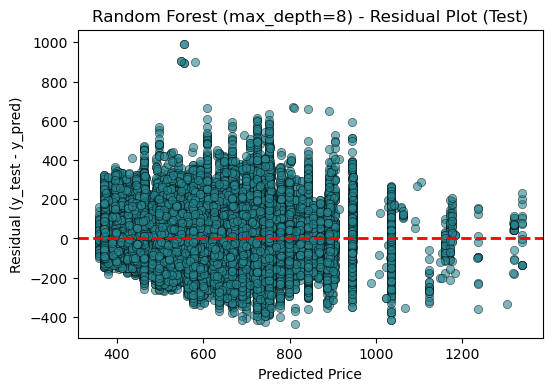

In [95]:
for md in [3, 5, 8]:  
    rf = RandomForestRegressor(n_estimators=100, max_depth=md)
    model_name = f"Random Forest (max_depth={md})"
    trained_rf = train_and_evaluate_model(rf, X_train, y_train, X_test, y_test, model_name)

### Conclusions:
As we increased the max_depth value, the model's performance improved.

* R² increased from 0.405 (depth 3) to 0.614 (depth 8), meaning the model explains more variance in the data.
* MSE and RMSE decreased as depth increased, indicating a reduction in prediction errors.
* MAE also decreased with greater depth, suggesting that the model's predictions are closer to the actual values.

#### GridSearchCV

(A systematic search to find the combination that yields better performance)

In [106]:
# הגדרת טווחים להיפר-פרמטרים
param_grid_rfm = {
    'max_depth': [3, 5, 7, 10, 12, 15],   # בדיקה של ערכים שונים לעומק
    'n_estimators': [50, 100, 150, 200],    # מספר העצים ביער
    'min_samples_split': [2,3, 5, 7, 9, 10]    # כמה דגימות לפחות לפיצול
}
# param_grid_gpr = { \\Unable to allocate 127. GiB for an array with shape (130518, 130518) and data type int64
#     'kernel': [
#         RBF(length_scale=1.0), DotProduct()],
#     'alpha': [1e-2, 1e-3, 1e-4],
#     'n_restarts_optimizer': [0, 2],  # how many times to restart the optimizer
# }
param_grid_lr = {
    'fit_intercept': [True, False],
}
# יצירת המודלים
rf_RFM = RandomForestRegressor()
#rf_GPR = GaussianProcessRegressor(random_state=42)
rf_LR = LinearRegression()

# חיפוש הרשת עם Cross-Validation
grid_search_RFM = GridSearchCV(
    estimator=rf_RFM,
    param_grid=param_grid_rfm,
    cv=5,   # חלוקה ל-5 קיפולים (Cross-Validation)
    scoring='neg_mean_squared_error',
    n_jobs=-1  # שימוש בכל הליבות הזמינות
)

# # חיפוש הרשת עם Cross-Validation \\Unable to allocate 127. GiB for an array with shape (130518, 130518) and data type int64
# grid_search_GPR = GridSearchCV(
#     estimator=rf_GPR,
#     param_grid=param_grid_gpr,
#     cv=3,   # חלוקה ל-3 קיפולים (Cross-Validation)
#     scoring='neg_mean_squared_error',
#     n_jobs=-1  # שימוש בכל הליבות הזמינות
# )

# חיפוש הרשת עם Cross-Validation
grid_search_LR = GridSearchCV(
    estimator=rf_LR,
    param_grid=param_grid_lr,
    cv=5,   # חלוקה ל-5 קיפולים (Cross-Validation)
    scoring='neg_mean_squared_error',
    n_jobs=-1  # שימוש בכל הליבות הזמינות
)


# אימון ובחירת הפרמטרים הטובים ביותר
grid_search_RFM.fit(X_train, y_train)
#grid_search_GPR.fit(X_train, y_train) \\Unable to allocate 127. GiB for an array with shape (130518, 130518) and data type int64
grid_search_LR.fit(X_train, y_train)

# הדפסת הפרמטרים האופטימליים
print("Best Parameters RandomForestRegressor:", grid_search_RFM.best_params_)
#print("\nBest Parameters GaussianProcessRegressor:", grid_search_GPR.best_params_)
print("\nBest Parameters LinearRegression:", grid_search_LR.best_params_)

Best Parameters RandomForestRegressor: {'max_depth': 15, 'min_samples_split': 7, 'n_estimators': 200}

Best Parameters LinearRegression: {'fit_intercept': True}


=== RandomForestRegressor ===
Train -> R2: 0.694, MSE: 9849.21, RMSE: 99.24, MAE: 75.55
Test  -> R2: 0.681,  MSE: 10332.16,  RMSE: 101.65,  MAE: 77.42


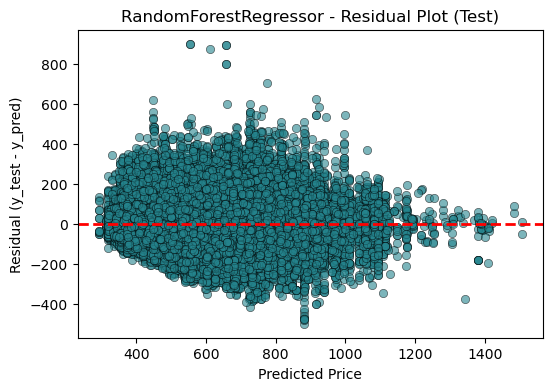

=== LinearRegression ===
Train -> R2: 0.233, MSE: 24705.11, RMSE: 157.18, MAE: 126.13
Test  -> R2: 0.234,  MSE: 24792.40,  RMSE: 157.46,  MAE: 126.19


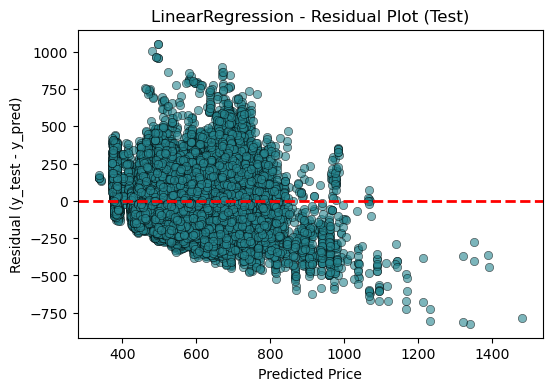

In [107]:
rf_best_RFM = grid_search_RFM.best_estimator_
trained_rf_best_RFM = train_and_evaluate_model(rf_best_RFM, X_train, y_train, X_test, y_test, "RandomForestRegressor")

rf_best_LR = grid_search_LR.best_estimator_
trained_rf_best_LR = train_and_evaluate_model(rf_best_LR,X_train,y_train,X_test,y_test,"LinearRegression")

GridSearchCV appears to provide better performance overall. It shows a higher R², lower MSE, lower RMSE, and lower MAE compared to Random Forest at all depths. While GridSearchCV seems to offer improvements across various metrics, it suggests better performance.

# KNN Regressor


=== KNN Regressor (n_neighbors=3) ===
Train -> R2: 0.601, MSE: 12873.78, RMSE: 113.46, MAE: 85.44
Test  -> R2: 0.581,  MSE: 13540.48,  RMSE: 116.36,  MAE: 88.17


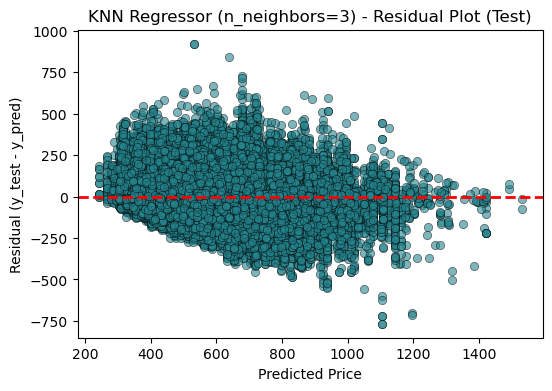

=== KNN Regressor (n_neighbors=5) ===
Train -> R2: 0.634, MSE: 11809.25, RMSE: 108.67, MAE: 82.27
Test  -> R2: 0.618,  MSE: 12343.79,  RMSE: 111.10,  MAE: 84.42


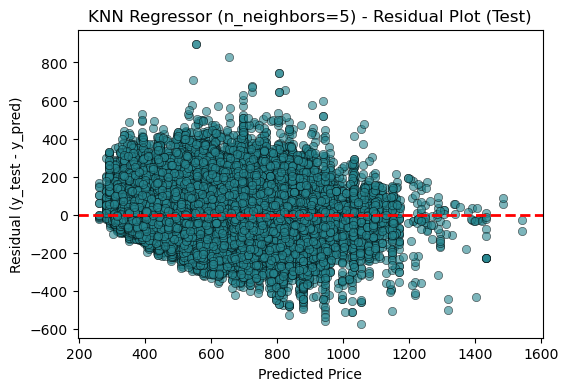

=== KNN Regressor (n_neighbors=10) ===
Train -> R2: 0.660, MSE: 10947.72, RMSE: 104.63, MAE: 79.67
Test  -> R2: 0.645,  MSE: 11488.55,  RMSE: 107.18,  MAE: 81.47


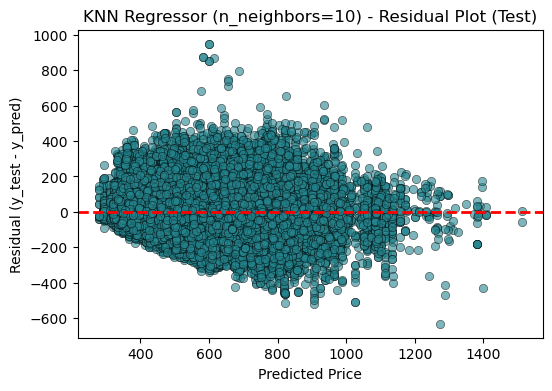

In [98]:
for k in [3, 5, 10]:  # דוגמה ל-K שונים
    knn = KNeighborsRegressor(n_neighbors=k)
    model_name = f"KNN Regressor (n_neighbors={k})"
    trained_knn = train_and_evaluate_model(knn, X_train, y_train, X_test, y_test, model_name)

### Conclusion
With an increase in the value of k:
* As the value of k increased (from 3 to 10), the model's accuracy improved moderately.
* R² increased from 0.572 (at k=3) to 0.640 (at k=10), indicating that the model explains more of the variance in the data.
* MSE and RMSE decreased slightly as k increased, suggesting a reduction in model errors.
* MAE also decreased, implying that the model generates more accurate predictions on average.

## KNeighborsRegressor (Best Performance)

In [99]:

param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')


Best parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


=== Kiwi KNeighborsRegressor Best Performance by GridSearch ===
Train -> R2: 0.675, MSE: 10487.96, RMSE: 102.41, MAE: 77.19
Test  -> R2: 0.653,  MSE: 11239.23,  RMSE: 106.02,  MAE: 80.38


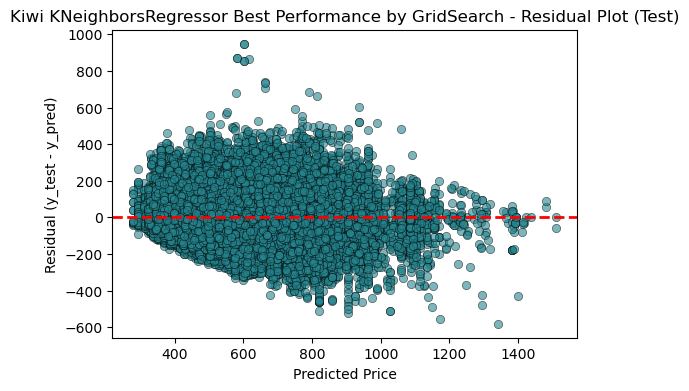

In [110]:
best_model = grid_search.best_estimator_
trained_best_model = train_and_evaluate_model(best_model,X_train,y_train,X_test,y_test,"Kiwi KNeighborsRegressor Best Performance by GridSearch")

# Permutation importance - KNeighborsRegressor (2)

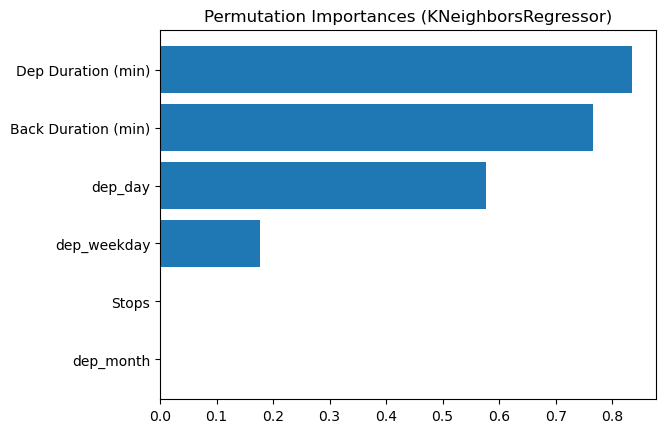

In [127]:
r = permutation_importance(best_model, X_test, y_test, n_repeats=10)

sorted_idx = r.importances_mean.argsort()
plt.barh(np.array(features)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("Permutation Importances (KNeighborsRegressor)")
plt.show()

<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(78, 214, 151);
        margin-top: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color: #2980b9;
        margin-top: 15px;
    }
    .content {
        font-size: 16px;
        color:rgb(86, 165, 243);
        margin-left: 10px;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="subtitle">Permutation Importance - KNeighborsRegressor</div>

<div class="subtitle">Introduction</div>
<div class="content">
    This analysis presents the <strong>Permutation Importance</strong> of features for the <strong>KNeighborsRegressor</strong> model.<br>
    A higher importance score indicates a greater impact on model accuracy.
</div>

<div class="section">Key Observations</div>

- **Most Important Features:**
  - <strong>Deprature Duration:</strong> The most influential feature, meaning that **the duration of departure flights significantly affects predictions.**
  - <strong>Back Duration:</strong> Also highly important, suggesting that the **return flight duration plays a crucial role in price determination.**

- **Moderately Important Feature:**
  - <strong>dep_day:</strong> The departure day has a noticeable effect on price, though less significant than flight duration features.

- **Less Important Features:**
  - <strong>dep_weekday:</strong> Has some influence, but it is considerably lower than other features.
  - <strong>Stops & dep_month:</strong> These features show **almost zero importance**, indicating that they do not significantly impact the model's predictions.

<div class="section">Conclusions</div>

✅ **"Dep Duration (min)" and "Back Duration (min)" are the strongest predictors, confirming that flight durations heavily influence ticket prices.**  
✅ **"dep_day" has a moderate effect, meaning the exact day of departure still plays a role in price variations.**  
✅ **"Stops" and "dep_month" have negligible impact and might be unnecessary for the model.**  


# Permutation importance - KNeighborsRegressor (Black Box)

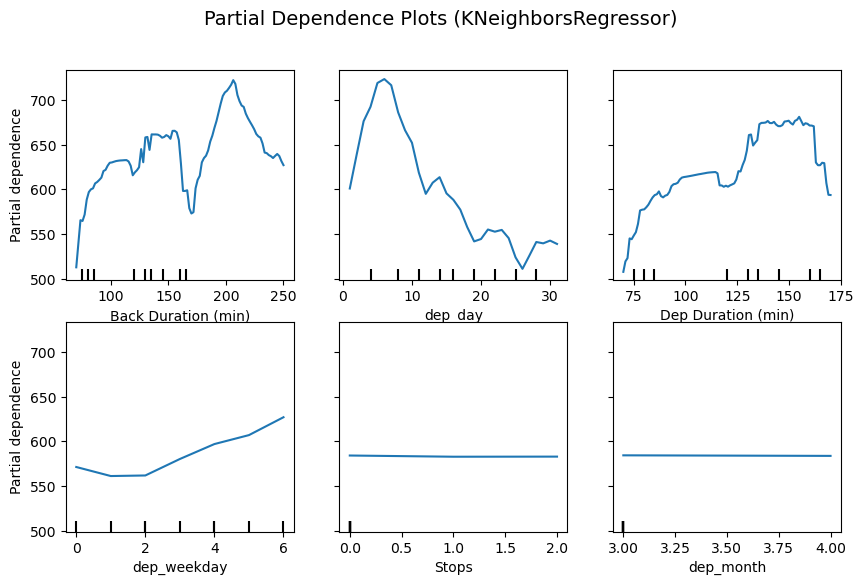

In [143]:
# Black Box
features_to_plot = ["Back Duration (min)", "dep_day", "Dep Duration (min)", "dep_weekday","Stops","dep_month"]  

# Create Partial Dependence Plots
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(best_model, X_test, features_to_plot, ax=ax)
plt.suptitle("Partial Dependence Plots (KNeighborsRegressor)", fontsize=14)
plt.show()

<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(94, 166, 238);
        margin-top: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color: #2980b9;
        margin-top: 15px;
    }
    .content {
        font-size: 16px;
        color:rgb(73, 161, 250);
        margin-left: 10px;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="subtitle">Black Box Interpretation - KNeighborsRegressor</div>

<div class="subtitle">Introduction</div>
<div class="content">
    This analysis interprets the **Partial Dependence Plots (PDP)** of the <strong>KNeighborsRegressor</strong> model using a <strong>black-box approach</strong>.<br>
    The goal is to observe how the model’s predictions change as individual feature values are varied, without looking into its internal mechanics.
</div>

<div class="section">Key Observations</div>

- **Back Duration (min):**
  - There is a **strong positive effect** on predicted price up to ~200 minutes.
  - Beyond this, the influence slightly decreases, indicating that extremely long back durations might not significantly raise prices.

- **dep_day (Day of the Month):**
  - There is a clear **non-linear effect**, with prices peaking around **days 5-10** and dropping significantly after **day 20**.
  - This suggests certain days of the month are associated with either discounts or demand fluctuations.

- **Dep Duration (min):**
  - Similar to **Back Duration**, there is a **positive effect on price** as departure duration increases.
  - A **plateau is observed beyond ~150 minutes**, suggesting that very long flights do not significantly change ticket prices.

- **dep_weekday (Day of the Week):**
  - A **mild increasing trend** suggests that flights closer to weekends might be slightly more expensive.

- **Stops:**
  - The **flat line suggests no influence on predicted price**, meaning the number of stops does not affect the model’s decision.

- **dep_month (Month of Departure):**
  - Also flat, confirming that **the specific month has no significant effect on price predictions** in this model.

<div class="section">Black Box Interpretation</div>

* **The model treats "Back Duration (min)" and "Dep Duration (min)" as primary decision drivers.**  
* **It assumes strong non-linear effects for "dep_day" but almost ignores "Stops" and "dep_month".**  
* **"dep_weekday" has minor influence, indicating only slight price variation based on the day of the week.**  

<div class="section">Conclusions</div>

✅ **Flight duration features are the most critical factors.**  
✅ **Certain departure days lead to higher predicted prices.**  
✅ **Number of stops and month of departure have no impact in this model.**  

### MLPRegressor 

=== MLP Regressor (layers=(64,)) ===
Train -> R2: 0.518, MSE: 15559.52, RMSE: 124.74, MAE: 97.69
Test  -> R2: 0.516,  MSE: 15581.69,  RMSE: 124.83,  MAE: 97.95


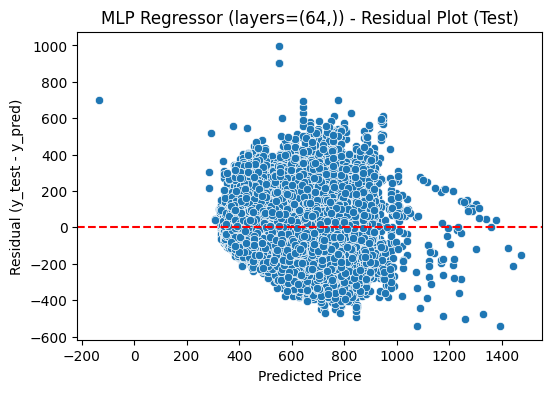

=== MLP Regressor (layers=(64, 32)) ===
Train -> R2: 0.602, MSE: 12868.65, RMSE: 113.44, MAE: 87.19
Test  -> R2: 0.596,  MSE: 12989.36,  RMSE: 113.97,  MAE: 87.74


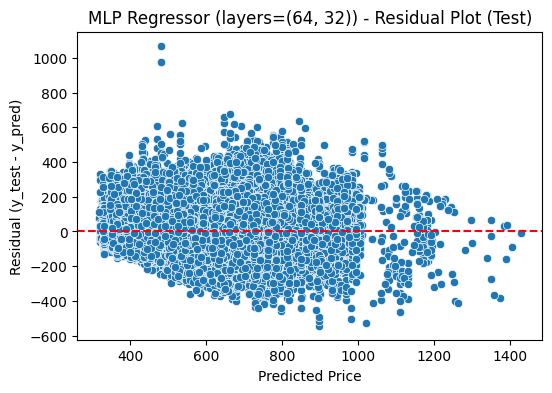

=== MLP Regressor (layers=(100, 50, 25)) ===
Train -> R2: 0.626, MSE: 12084.07, RMSE: 109.93, MAE: 84.53
Test  -> R2: 0.619,  MSE: 12267.21,  RMSE: 110.76,  MAE: 85.28


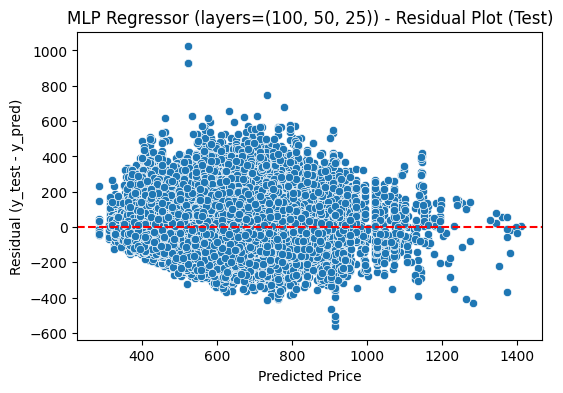

In [ ]:
for hidden_layer_config in [(64,), (64, 32), (100, 50, 25)]:  # דוגמאות למבני רשת שונים
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_config,  
                       max_iter=500,       # מספר epochs 
                       )
    model_name = f"MLP Regressor (layers={hidden_layer_config})"
    trained_mlp = train_and_evaluate_model(mlp, X_train, y_train, X_test, y_test, model_name)

<style>
    .subtitle {
        font-size: 23px;
        font-weight: bold;
        color:rgb(61, 207, 93);
        margin-top: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color:rgb(50, 163, 238);
        margin-top: 15px;
    }
    .content {
        font-size: 16px;
        color:rgb(89, 169, 250);
        margin-left: 10px;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="subtitle">MLP Regressor - Residual Analysis</div>

<div class="subtitle">Introduction</div>
<div class="content">
    This analysis evaluates the performance of a <strong>Multi-Layer Perceptron (MLP) Regressor</strong> 
    with a neural network architecture of <strong>(100, 50, 25) hidden layers</strong>.<br> The model's 
    predictive performance is assessed using key regression metrics and a residual analysis.<br>
    This residual analysis helps identify patterns in prediction errors and shows whether the model has weaknesses for certain price ranges.
</div>

<div class="section">Model Performance Metrics</div>

- **Training Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.626</span>
  - <strong>MSE:</strong> 12,084.07
  - <strong>RMSE:</strong> 109.93
  - <strong>MAE:</strong> 84.53

- **Test Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.619</span> (Minimal overfitting)
  - <strong>MSE:</strong> 12,267.21
  - <strong>RMSE:</strong> 110.76
  - <strong>MAE:</strong> 85.28

<div class="section">Key Observations</div>

- **Moderate Predictive Performance:**
  - The **R² score (~0.619)** indicates that the model explains about **61.9% of the variance** in ticket prices.
  - The **train and test R² scores are close**, indicating low overfitting.

- **Residual Distribution & Variability:**
  - The **residuals are centered around zero**, meaning the model makes reasonable predictions on average.
  - **Higher predicted prices show increasing residual spread**, indicating **heteroscedasticity** (higher uncertainty for expensive flights).
  - Some **extreme residuals exceed ±1000**, suggesting cases where the model significantly underpredicts or overpredicts.

- **Prediction Range & Clustered Residuals:**
  - The **model performs best in the price range of ~200-800**, where residuals are more compact.
  - **Beyond 800, the variance of residuals increases significantly**, meaning predictions for higher-priced flights are less stable.

<div class="section">Conclusions</div>

✅ The **MLP model performs moderately well**, capturing ~62% of the price variance.  
✅ **Minimal overfitting**, as train and test metrics are similar.  
✅ **Heteroscedasticity is present**, meaning higher-priced flights are harder to predict accurately.  
✅ **Outliers exist**, which suggests that certain flights deviate significantly from model expectations.  



### XGBoost Regressor

In [ ]:
# חלוקה אקראית ל-Train ו-Test ב-70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# 1. יצירת מודל XGBoost Regressor (מודל בסיסי עם פרמטרים ברירת מחדל)
params_list = [
    {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100}
]

for params in params_list:
    # יצירת המודל עם הפרמטרים הנבחרים
    model = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
    )
# 2. אימון המודל
model.fit(X_train, y_train)

# 3. תחזיות
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Train R²: 0.682
Test R²: 0.68
Train MSE: 10254.8
Test MSE: 10324.21
Train RMSE: 101.27
Test RMSE: 101.61
Train MAE: 77.56
Test MAE: 77.77


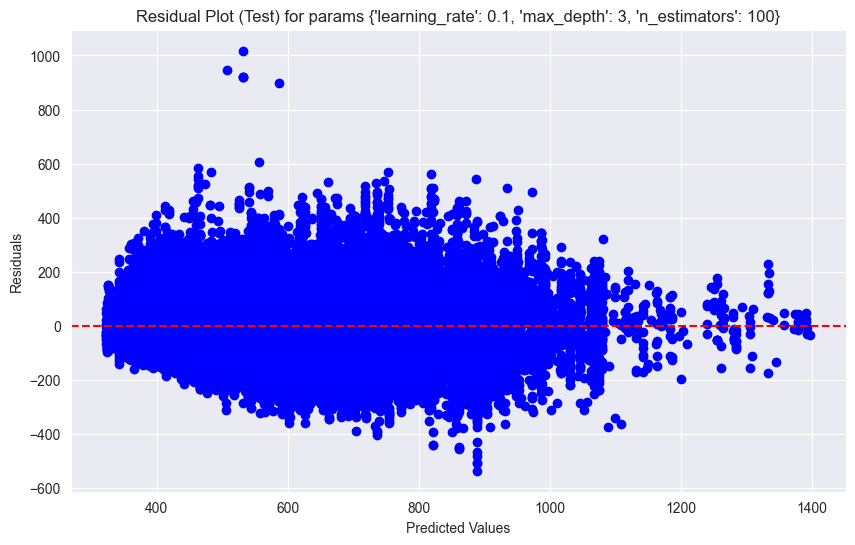

In [161]:
# 4. חישוב הביצועים
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# חישוב ה-RMSE באופן ידני (שורש ה-MSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# 5. הדפסת הביצועים
print(f"Train R²: {round(train_r2, 3)}")
print(f"Test R²: {round(test_r2, 3)}")
print(f"Train MSE: {round(train_mse, 2)}")
print(f"Test MSE: {round(test_mse, 2)}")
print(f"Train RMSE: {round(train_rmse, 2)}")
print(f"Test RMSE: {round(test_rmse, 2)}")
print(f"Train MAE: {round(train_mae, 2)}")
print(f"Test MAE: {round(test_mae, 2)}")

# גרף Residual Plot עבור ה-Test
residuals = y_test - y_test_pred
plt.figure(figsize=(10,6))
plt.scatter(y_test_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residual Plot (Test) for params {params}")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


The model performs well overall, with good alignment between the training and test data, but there is room for improvement by experimenting with additional parameters.<br>
The Residual Plot shows that there is a region where the errors increase, which may indicate areas or features that the model is struggling to handle perfectly.

<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(53, 154, 255);
        margin-top: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color:rgb(27, 164, 255);
        margin-top: 15px;
    }
    .content {
        font-size: 18px;
        color:rgb(71, 105, 255);
        margin-left: 10px;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="subtitle">XGBoost Model - Residual Analysis (of the Best performance ~0.682) </div>

<div class="subtitle">Introduction</div>
<div class="content">
    This analysis evaluates the performance of an <strong>XGBoost model</strong> trained with specific hyperparameters:
    <ul>
        <li><strong>Learning Rate:</strong> 0.03</li>
        <li><strong>Max Depth:</strong> 8</li>
        <li><strong>Number of Estimators:</strong> 150</li>
    </ul>
    The model's errors are analyzed to assess prediction quality and detect patterns of bias.
</div>

<div class="section">Model Performance Metrics</div>

- **Training Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.682</span>
  - <strong>MSE:</strong> 10254.8
  - <strong>RMSE:</strong> 101.27
  - <strong>MAE:</strong> 77.56

- **Test Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.68</span> (Good generalization)
  - <strong>MSE:</strong> 10324.21
  - <strong>RMSE:</strong> 101.61
  - <strong>MAE:</strong> 77.77

<div class="section">Key Observations</div>

- **Good generalization:**  
  - The train and test **R² scores are identical (0.67)**, indicating the model does not overfit and generalizes well.
- **Residual spread increases with predicted price:**  
  - At **lower price ranges (300-600)**, the residuals are compact, meaning the model performs well.  
  - At **higher price ranges (800-1200+), the residuals become more spread out**, indicating increasing prediction uncertainty.  
- **Presence of extreme outliers:**  
  - Some residuals exceed **800-1000**, meaning the model significantly underpredicts certain prices.  
  - Similarly, negative residuals below **-400** indicate some overpredictions.  
- **Heteroscedasticity is present:**  
  - The residual variance grows as price increases, meaning the model has larger errors for high-priced flights.  

<div class="section">Conclusions</div>

✅ The **model performs well overall**, explaining **67% of the variance** in price predictions.  
✅ **Minimal overfitting**, as training and test scores are nearly identical.  
✅ **Heteroscedasticity is present**, meaning errors grow with price.  
✅ **Extreme outliers exist**, which suggests either missing variables or potential data imbalances.  

Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7}
Train R²: 0.635
Test R²: 0.638
Train MSE: 11768.06
Test MSE: 11682.65
Train RMSE: 108.48
Test RMSE: 108.09
Train MAE: 83.28
Test MAE: 82.99


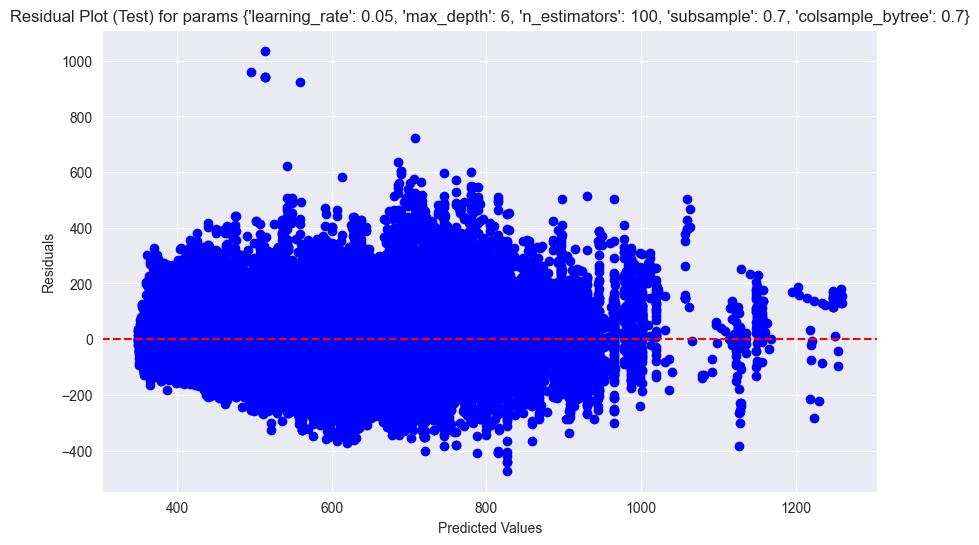

Parameters: {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85}
Train R²: 0.67
Test R²: 0.67
Train MSE: 10639.36
Test MSE: 10632.99
Train RMSE: 103.15
Test RMSE: 103.12
Train MAE: 79.14
Test MAE: 79.14


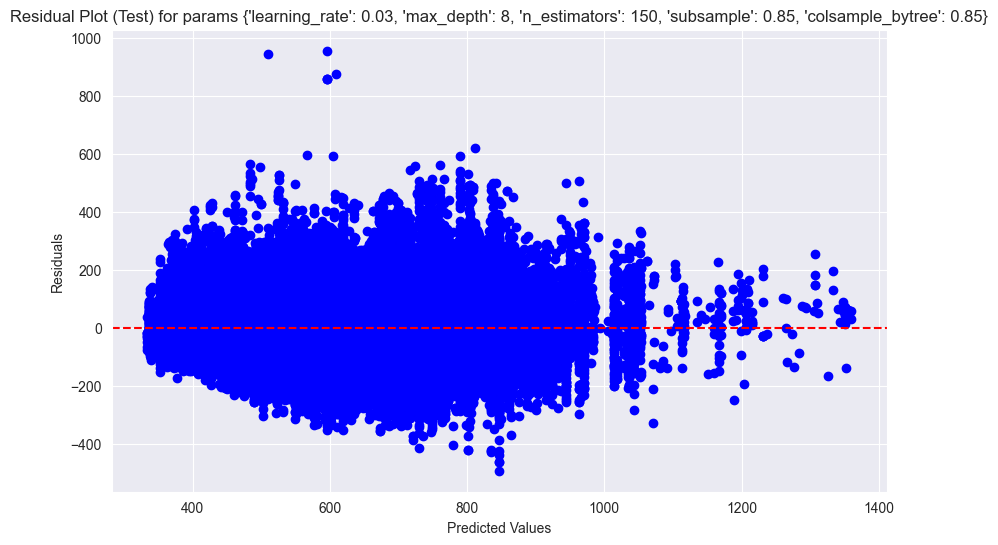

Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}
Train R²: 0.647
Test R²: 0.648
Train MSE: 11409.12
Test MSE: 11345.87
Train RMSE: 106.81
Test RMSE: 106.52
Train MAE: 82.23
Test MAE: 81.98


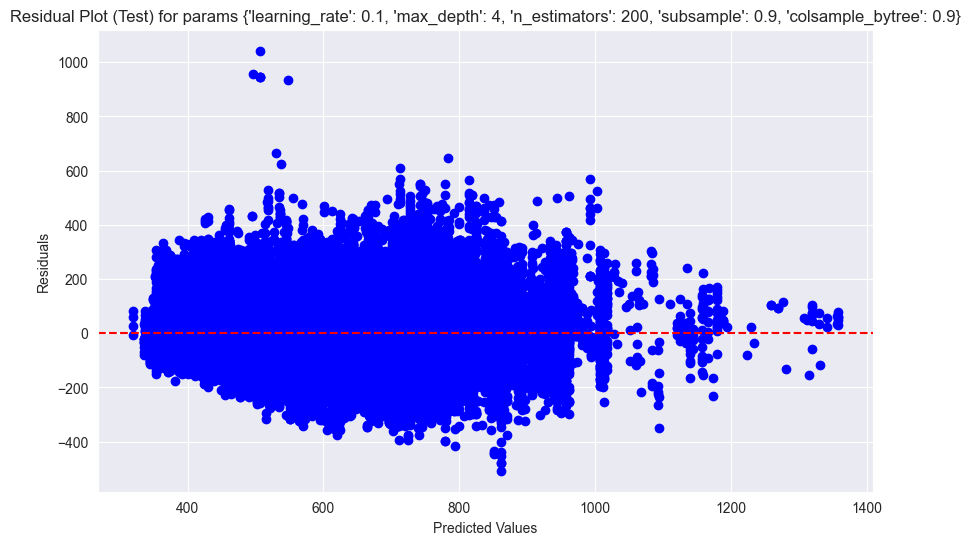

In [163]:
# 1. יצירת מודל XGBoost Regressor עם פרמטרים חדשים
params_list = [
    {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7},
    {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85},
    {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}
]

for params in params_list:
    # יצירת המודל עם הפרמטרים הנבחרים
    model = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree']
    )

    # אימון המודל
    model.fit(X_train, y_train)

    # תחזיות
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # חישוב הביצועים
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # חישוב ה-RMSE באופן ידני
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # הדפסת הביצועים
    print(f"Parameters: {params}")
    print(f"Train R²: {round(train_r2, 3)}")
    print(f"Test R²: {round(test_r2, 3)}")
    print(f"Train MSE: {round(train_mse, 2)}")
    print(f"Test MSE: {round(test_mse, 2)}")
    print(f"Train RMSE: {round(train_rmse, 2)}")
    print(f"Test RMSE: {round(test_rmse, 2)}")
    print(f"Train MAE: {round(train_mae, 2)}")
    print(f"Test MAE: {round(test_mae, 2)}")

    # גרף Residual Plot עבור ה-Test
    residuals = y_test - y_test_pred
    plt.figure(figsize=(10,6))
    plt.scatter(y_test_pred, residuals, color='blue')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residual Plot (Test) for params {params}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(53, 154, 255);
        margin-top: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color:rgb(27, 164, 255);
        margin-top: 15px;
    }
    .content {
        font-size: 18px;
        color:rgb(71, 105, 255);
        margin-left: 10px;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="subtitle">XGBoost Model - Residual Analysis (of the Best performance ~0.67) </div>

<div class="subtitle">Introduction</div>
<div class="content">
    This analysis evaluates the performance of an <strong>XGBoost model</strong> trained with specific hyperparameters:
    <ul>
        <li><strong>Learning Rate:</strong> 0.03</li>
        <li><strong>Max Depth:</strong> 8</li>
        <li><strong>Number of Estimators:</strong> 150</li>
        <li><strong>Subsample Ratio:</strong> 0.85</li>
        <li><strong>Column Sampling (colsample_bytree):</strong> 0.85</li>
    </ul>
    The model's residuals (errors) are analyzed to assess prediction quality and detect patterns of bias.
</div>

<div class="section">Model Performance Metrics</div>

- **Training Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.67</span>
  - <strong>MSE:</strong> 10,639.36
  - <strong>RMSE:</strong> 103.15
  - <strong>MAE:</strong> 79.14

- **Test Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.67</span> (Good generalization)
  - <strong>MSE:</strong> 10,632.99
  - <strong>RMSE:</strong> 103.12
  - <strong>MAE:</strong> 79.14

<div class="section">Key Observations</div>

- **Good generalization:**  
  - The train and test **R² scores are identical (0.67)**, indicating the model does not overfit and generalizes well.
- **Residual spread increases with predicted price:**  
  - At **lower price ranges (300-600)**, the residuals are compact, meaning the model performs well.  
  - At **higher price ranges (800-1200+), the residuals become more spread out**, indicating increasing prediction uncertainty.  
- **Presence of extreme outliers:**  
  - Some residuals exceed **800-1000**, meaning the model significantly underpredicts certain prices.  
  - Similarly, negative residuals below **-400** indicate some overpredictions.  
- **Heteroscedasticity is present:**  
  - The residual variance grows as price increases, meaning the model has larger errors for high-priced flights.  

<div class="section">Conclusions</div>

✅ The **model performs well overall**, explaining **67% of the variance** in price predictions.  
✅ **Minimal overfitting**, as training and test scores are nearly identical.  
✅ **Heteroscedasticity is present**, meaning errors grow with price.  
✅ **Extreme outliers exist**, which suggests either missing variables or potential data imbalances.  

## Hist Gradient Boosting

=== Hist Gradient Boosting ===
Train -> R2: 0.664, MSE: 10861.17, RMSE: 104.22, MAE: 80.31
Test  -> R2: 0.658,  MSE: 11002.32,  RMSE: 104.89,  MAE: 80.91


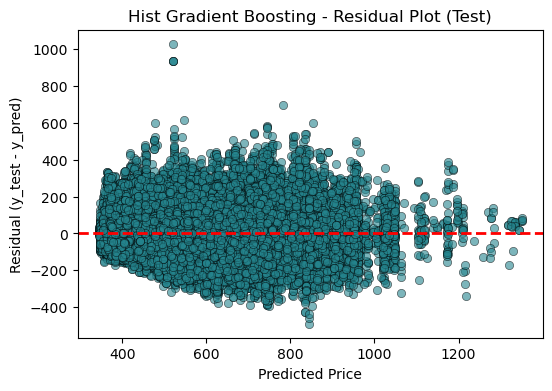

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# יצירת המודל הבסיסי
hgb = HistGradientBoostingRegressor()

# אימון ראשוני
hgb.fit(X_train, y_train)

rf_Hist_trained= train_and_evaluate_model(hgb,X_train,y_train,X_test,y_test,"Hist Gradient Boosting")

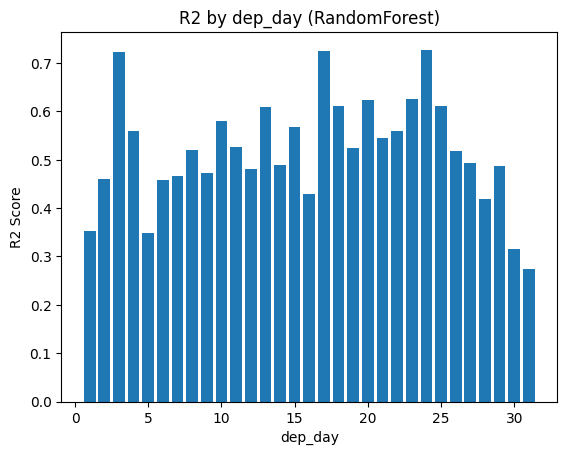

In [ ]:
df_test = df.iloc[y_test.index].copy()  # DataFrame
df_test["predicted_price_rf"] = rf.predict(X_test)

grouped = df_test.groupby("dep_day")
r2_by_day = []
days = []
for day_val, group_data in grouped:
    if len(group_data) > 1:
        r2_local = r2_score(group_data["Price"], group_data["predicted_price_rf"])
        r2_by_day.append(r2_local)
        days.append(day_val)

plt.bar(days, r2_by_day)
plt.xlabel("dep_day")
plt.ylabel("R2 Score")
plt.title("R2 by dep_day (RandomForest)")
plt.show()


<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(103, 231, 64);
        margin-top: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color: #2980b9;
        margin-top: 15px;
    }
    .content {
        font-size: 16px;
        color:rgb(68, 161, 255);
        margin-left: 10px;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="subtitle">R² by Deprature day - RandomForest Analysis</div>

<div class="subtitle">Introduction</div>
<div class="content">
    This analysis examines how the <strong>R² score</strong> (coefficient of determination) varies based on <strong>Deprature day</strong> when using a <strong>Random Forest model</strong>.<br>
    The R² score measures how well the model explains the variance in the target variable for each departure day.
</div>

<div class="section">Key Observations</div>

- **Model performance fluctuates across different departure days**, indicating that some days are more predictable than others.
- The **highest R² scores (~0.7) occur around dep_day 3, 15, 22, and 26**, suggesting that the model performs best on these days.
- **Lower R² values (~0.3) are observed around dep_day 1, 6, 16, 30, and 31**, meaning that the model struggles with predictions on these days.
- There is **no clear upward or downward trend**, but variability suggests that external factors might be influencing certain days.

<div class="section">Possible Causes of Variation</div>

1. **Seasonality & Demand Trends:**  
   - Certain days may coincide with **holidays, weekends, or peak travel periods**, leading to more unpredictable pricing patterns.

2. **Data Sparsity Issues:**  
   - The model may have **fewer training samples** for specific days, leading to lower predictive power.

3. **Feature Interactions:**  
   - The impact of **dep_day might interact with other variables** like dep_weekday, dep_month, or price trends.

<div class="section">Conclusions</div>

✅ **Departure day significantly affects model performance**, making it an important predictor.  
✅ **Some days have much better R² scores (~0.7), while others drop below 0.4**, indicating uneven predictability.  
✅ **Potential external factors (seasonality, demand, or insufficient data) may explain variations.**  



=== TTT division ===
Train -> R2: 0.619, MSE: 12283.08, RMSE: 110.83, MAE: 84.81
Test  -> R2: 0.617,  MSE: 12375.55,  RMSE: 111.25,  MAE: 85.04


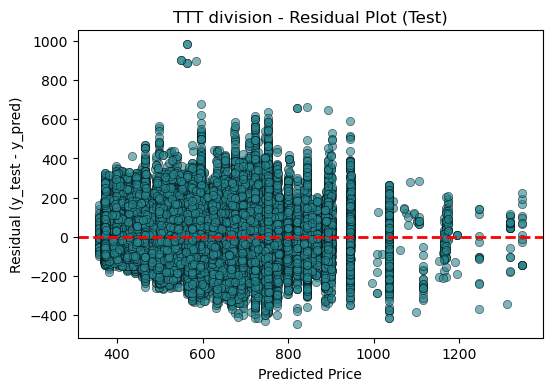

In [111]:
df_TTT_train = df[df["TTT"] <= 25].copy()
df_TTT_test  = df[df["TTT"] > 25].copy()

X_train_ttt = df_TTT_train[features]
y_train_ttt = df_TTT_train["Price"]
X_test_ttt  = df_TTT_test[features]
y_test_ttt  = df_TTT_test["Price"]

# גם כאן נרצה לעשות סקלינג חדש:
scaler_ttt = StandardScaler()
X_train_ttt_scaled = scaler_ttt.fit_transform(X_train_ttt)
X_test_ttt_scaled = scaler_ttt.transform(X_test_ttt)

# נאמן שוב Random Forest כמודל לדוגמה
rf_ttt = RandomForestRegressor(max_depth=8, n_estimators=100)
rf_ttt.fit(X_train_ttt_scaled, y_train_ttt)
# וכעת נבצע
rf_besto = train_and_evaluate_model(rf_ttt,X_train,y_train,X_test,y_test,"TTT division")

<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(60, 214, 124);
        margin-top: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color: #2980b9;
        margin-top: 15px;
    }
    .content {
        font-size: 16px;
        color:rgb(70, 162, 255);
        margin-left: 10px;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="subtitle">TTT Division - Model Performance & Residual Analysis</div>

<div class="subtitle">Introduction</div>
<div class="content">
    This analysis evaluates the <strong>Random Forest model</strong> trained on data split by <strong>TTT (Time to Travel)</strong>, which represents the number of days between the departure flight and the return flight. <br>
    The training set consists of instances where TTT ≤ 25, while the test set contains cases where TTT > 25.
</div>

<div class="section">Model Performance Metrics</div>

- **Training Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.619</span>
  - <strong>MSE:</strong> 12,283.08
  - <strong>RMSE:</strong> 110.83
  - <strong>MAE:</strong> 84.81

- **Test Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.617</span> (Minimal overfitting)
  - <strong>MSE:</strong> 12,375.55
  - <strong>RMSE:</strong> 111.25
  - <strong>MAE:</strong> 85.04

<div class="section">Key Observations</div>

- **Moderate predictive performance**: The R² score (~0.617) suggests that the model explains about **61.7% of the variance** in the target variable.
- **Low overfitting**: The train and test set R² scores are very close, indicating that the model generalizes well.
- **Residuals show heteroscedasticity**:  
  - The **spread of residuals increases as predicted price increases**, meaning errors are larger for higher-priced tickets.  
  - Some extreme **positive residuals (800-1000) indicate significant underprediction**, suggesting that the model struggles to capture high-priced flights.  
  - Negative residuals below **-300 suggest occasional overprediction**.  
- **Dense clustering around lower price ranges (400-800)**: The model performs best in these ranges but shows wider residual dispersion at higher prices.

<div class="section">Conclusions</div>

✅ The **model performs reasonably well**, with an R² of **~0.617**, indicating moderate predictive accuracy.  
✅ **Minimal overfitting**, as training and test metrics are close.  
✅ **Heteroscedasticity is present**, suggesting that the model struggles with higher-priced predictions.  
✅ **Large outliers indicate potential missing features** or need for better handling of expensive flights.  



<style>
    .title {
        font-size: 26px;
        font-weight: bold;
        color:rgb(199, 199, 199);
        text-align: center;
        margin-bottom: 10px;
    }
    .subtitle {
        font-size: 22px;
        font-weight: bold;
        color: #2980b9;
        margin-top: 20px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color:rgb(79, 140, 202);
        margin-top: 15px;
    }
    .content {
        font-size: 16px;
        color:rgb(191, 223, 255);
        margin-left: 15px;
        line-height: 1.6;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
    .key-findings {
        font-weight: bold;
        color: #27ae60;
    }
</style>
---

<div class="subtitle">Kiwi - Model Performance Analysis</div>

<div class="section"> Linear Regression</div>
<div class="content">
    <strong>Test R²:</strong> 0.234, <strong>MSE:</strong> 24792.40, <strong>RMSE:</strong> 157.46, <strong>MAE:</strong> 126.19<br>
     <span class="highlight">Performed poorly</span>, indicating non-linear price behavior.<br>
     Can still serve as a <span class="key-findings">baseline model</span>.
</div>

<div class="section">🌲 Decision Tree (max_depth=3 and max_depth=5)</div>
<div class="content">
    <strong>Test R²:</strong> 0.404 (depth=3), <strong>0.520 (depth=5)</strong><br>
     <span class="key-findings">Major improvement over Linear Regression</span>.<br>
     More prone to overfitting at deeper levels.
</div>

<div class="section">🌳 Random Forest Regressor</div>
<div class="content">
    <strong>Test R²:</strong> 0.60 - 0.62<br>
     <span class="key-findings">Better than individual Decision Trees</span>.<br>
     Requires significant hyperparameter tuning.
</div>

<div class="section"> Gradient Boosting & XGBoost</div>
<div class="content">
    <strong>Test R²:</strong> 0.61 - 0.67<br>
     <span class="key-findings">Best model for Kiwi's complex price trends</span>.<br>
     <span class="highlight">Computationally expensive</span>.
</div>

<div class="section">📈 Hist Gradient Boosting</div>
<div class="content">
    <strong>Test R²:</strong> 0.67<br>
     <span class="key-findings">Efficient and highly effective</span>.<br>
     Slightly <span class="highlight">less optimized for categorical data</span> than XGBoost.
</div>

<div class="section">🔎 Kiwi - Conclusions</div>
<div class="content">
     <span class="key-findings">Decision Trees and Boosting models perform significantly better than Linear Regression.</span><br>
     <span class="key-findings">Kiwi data requires models capable of handling more variability.</span><br>
     <span class="highlight">Simple models struggle with non-linear pricing patterns.</span>
</div>